In [1]:
import numba as nb
import numpy as np


In [2]:
from css_matrix_completion.css import uniform
from utils.data_generation import create_rank_k_dataset
import numpy as np

M, M_incomplete, omega, mask_array = create_rank_k_dataset(100, 100, 10, gaussian=True)
cols_selected = uniform(M, 50)
C = M[:, cols_selected]
#
# M = np.asfortranarray(M)
# C = np.asfortranarray(C)
# mask_array = np.asfortranarray(mask_array)
# print(f'D {np.isfortran(C)}')
#
# C = np.ascontiguousarray(C)

In [3]:
@nb.njit(nb.float64[:,:](nb.float64[:,:],nb.boolean[:,:], nb.float64[:, :]), parallel=True, nogil=True)
def cx(X, ok_mask, D):
    # m, n = X.shape
    m, n = X.shape
    _, k = D.shape
    Y = np.zeros((n, k))
    # For each row, solve a k-dimensional regression problem
    # only over the nonp.isfortran(nzero projection entries. Note that the
    # projection changes the least-squares matrix siX so we
    # cannot vectorize the outer loop.
    for i in nb.prange(n):
        si = np.copy(ok_mask[:, i])
        sia = X[si, i]
        siX = D[si]
        Y[i, :] = np.linalg.lstsq(siX, sia)[0]
    # print(f'Y {np.isfortran(Y)}')
    # print(f'D {np.isfortran(D)}')
    # print(f'YT {np.isfortran(Y.T)}')
    return D@Y.T

/tmp/ipykernel_51398/3372862875.py:19: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, A), array(float64, 2d, F))
  return D@Y.T
/home/tosia/.pyenv/versions/3.9.5/lib/python3.8/site-packages/numba/core/typing/npydecl.py:913: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, A), array(float64, 2d, F))
  warnings.warn(NumbaPerformanceWarning(msg))


In [8]:
%%time
X = cx(M, mask_array, C)

CPU times: user 3min 1s, sys: 6min 54s, total: 9min 56s
Wall time: 1min 20s


In [7]:
from numba import types


#@nb.njit(types.Tuple((nb.float64[:], nb.float64[:]))(nb.float64[:,:],nb.float64[:,:]), parallel=True)
def fit(XX, yy):
    """"Fit a large set of points to a regression"""
    assert XX.shape == yy.shape, "Inputs mismatched"
    n_pnts, n_samples = XX.shape

    scale = np.empty(n_pnts)
    offset = np.empty(n_pnts)

    for i in nb.prange(n_pnts):
        X, y = XX[i], yy[i]
        A = np.vstack((np.ones_like(X), X)).T
        offset[i], scale[i] =  np.linalg.lstsq(A, y)[0]

    return offset, scale


In [17]:
XX, yy = np.random.randn(2, 1000,1000)
%%time
fit(XX, yy)

In [6]:
import numpy as np

def cx(X, ok_mask, C):
    m, n = X.shape
    _, k = C.shape
    Y = np.zeros((n, k))
    # For each row, solve a k-dimensional regression problem
    # only over the nonzero projection entries. Note that the
    # projection changes the least-squares matrix siX so we
    # cannot vectorize the outer loop.
    for i in range(n):
        si = ok_mask[:, i]
        sia = X[si, i]
        siX = C[si]
        Y[i, :] = np.linalg.lstsq(siX, sia)[0]
    return C@Y.T

cx(M, mask_array, C)

/tmp/ipykernel_13923/1134940552.py:15: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Y[i, :] = np.linalg.lstsq(siX, sia)[0]


array([[-6.81016576,  1.29227445, -1.59384695, ...,  1.82509451,
         0.71069245, -0.91610306],
       [-3.68628197,  0.07361209, -2.90964181, ..., -0.16190265,
         4.09533825,  2.9135026 ],
       [ 0.6028191 , -1.0232053 , -4.44192259, ..., -1.42835732,
         1.83011005,  1.32888591],
       ...,
       [-0.18568346, -2.3580204 , -0.46859365, ..., -0.90908786,
        -3.64575814,  2.39929203],
       [-1.61814118, -1.19700224,  0.41052628, ..., -1.57706502,
         2.93690241, -0.19560642],
       [-0.46351974, -2.87743598,  7.42933315, ..., -0.95331787,
         0.93849256,  2.2059717 ]])

In [19]:
#@nb.njit(nb.float64[:,:](nb.float64[:,:], nb.float64[:, ::1]), parallel=True)
def cx_all(X, D):
    # m, n = X.shape
    m, n = X.shape
    _, k = D.shape
    Y = np.zeros((n, k))
    # For each row, solve a k-dimensional regression problem
    # only over the nonp.isfortran(nzero projection entries. Note that the
    # projection changes the least-squares matrix siX so we
    # cannot vectorize the outer loop.
    for i in nb.prange(n):
        sia = X[:, i]
        siX = np.ones(D.shape)
        Y[i, :] = np.linalg.lstsq(siX, sia)[0]
    # print(f'Y {np.isfortran(Y)}')
    # print(f'D {np.isfortran(D)}')
    # print(f'YT {np.isfortran(Y.T)}')
    return Y.T

In [18]:
%%time
cx_all(M, C)

CPU times: user 3min 15s, sys: 7min 45s, total: 11min 1s
Wall time: 1min 26s


array([[-3.29018279e+12,  8.07221545e+11,  8.57921840e+11, ...,
         9.65313640e+11,  1.47952658e+12, -5.10188914e+11],
       [ 1.10447541e+12, -1.69947717e+11, -3.59894629e+11, ...,
        -4.06267638e+11, -4.98647537e+11,  3.03114845e+10],
       [ 1.10447541e+12, -1.69947717e+11, -3.59894629e+11, ...,
        -4.06267638e+11, -4.98647537e+11,  3.03114845e+10],
       ...,
       [-2.77610602e+10, -4.92988318e+09,  1.55946591e+10, ...,
         1.77004522e+10,  1.27146032e+10,  1.20760959e+10],
       [-2.77610602e+10, -4.92988318e+09,  1.55946591e+10, ...,
         1.77004522e+10,  1.27146032e+10,  1.20760959e+10],
       [-2.77563876e+10, -4.93116524e+09,  1.55935372e+10, ...,
         1.76991917e+10,  1.27125047e+10,  1.20770098e+10]])

In [20]:
%%time
cx_all(M, C)

/tmp/ipykernel_15739/2835844481.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Y[i, :] = np.linalg.lstsq(siX, sia)[0]


CPU times: user 6min 36s, sys: 8min 24s, total: 15min 1s
Wall time: 1min 59s


array([[-3.10162861e+12,  6.19504381e+11,  1.02909056e+12, ...,
         1.34751404e+12,  1.25290192e+12, -4.48310735e+11],
       [ 1.05856822e+12, -4.95930967e+10, -4.00858506e+11, ...,
        -5.54379916e+11, -3.73523619e+11, -1.26645540e+10],
       [ 1.05856822e+12, -4.95930967e+10, -4.00858506e+11, ...,
        -5.54379916e+11, -3.73523619e+11, -1.26645540e+10],
       ...,
       [-2.81940284e+10, -1.31767255e+10,  1.51228651e+10, ...,
         2.32289979e+10,  5.10358289e+09,  1.51780139e+10],
       [-2.81940284e+10, -1.31767255e+10,  1.51228651e+10, ...,
         2.32289979e+10,  5.10358289e+09,  1.51780139e+10],
       [-2.81940284e+10, -1.31767255e+10,  1.51228651e+10, ...,
         2.32289979e+10,  5.10358289e+09,  1.51780139e+10]])

In [12]:
import dask
import numba as nb

@nb.njit(nb.float64[:,:](nb.float64[:,:], nb.float64[:, :]), parallel=True, nogil=True)
def ls_grad(X, Y):
    _, s, _ = np.linalg.svd(2 * X.T.dot(X))
    step_size = 1 / s - 1e-8

    ## define some parameters
    max_steps = 100
    tol = 1e-8
    beta_hat = np.zeros(100) # initial guess
    m, n = X.shape
    _, k = Y.shape
    Beta = np.zeros((n, k))
    for i in nb.prange(n):
        y = Y[:, i]
        for k in range(max_steps):
            Xbeta = X.dot(beta_hat)
            func = ((y - Xbeta)**2).sum()
            gradient = 2 * X.T.dot(Xbeta - y)

            ## Update
            obeta = beta_hat
            beta_hat = beta_hat - step_size * gradient
            new_func = ((y - X.dot(beta_hat))**2).sum()
            beta_hat, func, new_func = dask.compute(beta_hat, func, new_func)  # <--- Dask code

            ## Check for convergence
            change = np.absolute(beta_hat - obeta).max()

            if change < tol:
                break
        Beta[i,:] = beta_hat
    return Beta


TypingError: Failed in nopython mode pipeline (step: nopython frontend)
Unknown attribute 'compute' of type Module(<module 'dask' from '/home/tosia/.pyenv/versions/3.9.5/lib/python3.8/site-packages/dask/__init__.py'>)

File "../../../../../tmp/ipykernel_9418/2537065620.py", line 27:
<source missing, REPL/exec in use?>

During: typing of get attribute at /tmp/ipykernel_9418/2537065620.py (27)

File "../../../../../tmp/ipykernel_9418/2537065620.py", line 27:
<source missing, REPL/exec in use?>


In [4]:
import dask
def grad_solve_dask(X, y):
    _, s, _ = np.linalg.svd(2 * X.T.dot(X))
    step_size = 1 / s - 1e-8

    ## define some parameters
    max_steps = 100
    tol = 1e-8
    beta_hat = np.zeros_like(y)# initial guess

    for k in range(max_steps):
        Xbeta = X.dot(beta_hat)
        func = ((y - Xbeta)**2).sum()
        gradient = 2 * X.T.dot(Xbeta - y)

        ## Update
        obeta = beta_hat
        beta_hat = beta_hat - step_size * gradient
        new_func = ((y - X.dot(beta_hat))**2).sum()
        beta_hat, func, new_func = dask.compute(beta_hat, func, new_func)  # <--- Dask code

        ## Check for convergence
        change = np.absolute(beta_hat - obeta).max()

        if change < tol:
            break
    return beta_hat

In [10]:
#@nb.njit(nb.float64[:](nb.float64[:,:]), nogil=True)
def step_size(X):
    A = X.T.dot(X)
    return A[3]
import scipy

In [24]:
%%timeit -n 10
step_size(M)

20.4 ms ± 6.32 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [4]:
%%timeit -n 10
step_size(M)

11.8 ms ± 6.44 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [7]:
%%timeit -n 10
_, s, _ = fbpca.svd(2 * M.T.dot(M))

279 ms ± 70.5 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [9]:
%%timeit -n 10
_, s, _ = np.linalg.svd(2 * M.T.dot(M))

342 ms ± 135 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [11]:
%%timeit -n 10
_, s, _ = scipy.linalg.svd(2 * M.T.dot(M))

288 ms ± 35.1 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [23]:
from dask_ml.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(M, C[:,1])
lr.predict(M)

array([ 3.53258203e+00, -5.36866908e-01,  2.40689925e+00,  1.30224555e+00,
       -3.17176930e-01,  2.09848103e+00, -7.40943348e-01, -1.72079575e+00,
       -2.67649968e+00, -2.10435349e+00, -2.66131205e+00, -6.78008866e-01,
       -1.00037339e+00, -2.12871844e+00,  2.02384459e+00,  2.78940788e+00,
        1.06624514e+00,  1.81258258e+00, -7.66224395e-01, -1.59604727e+00,
        3.36772852e-01, -2.63348098e+00,  1.89061009e+00,  2.76034091e+00,
       -2.60155693e+00, -1.69257110e+00, -2.30675230e+00, -1.44295694e+00,
        3.16728159e+00,  4.62913833e+00,  3.02218965e+00, -2.02207060e+00,
        6.22178665e+00,  2.60753262e+00, -2.07652029e+00,  3.83345298e+00,
       -1.61079765e+00, -1.14142419e+00, -1.71507140e+00,  4.04740148e+00,
        4.07226417e+00, -3.26133123e-01, -2.57254583e-01, -4.16734812e+00,
        1.75494788e-01, -2.71876718e+00, -8.63673658e-01,  1.34165444e+00,
       -1.38038977e+00,  1.64757847e+00,  2.67253272e-01,  4.44543901e-01,
        9.37086090e-01, -

In [17]:
C[:,0].shape

(1000,)

In [5]:
#%timeit -n 10
c = C[:,1]
grad_solve_dask(M, c)

/tmp/ipykernel_13923/485205517.py:19: RuntimeWarning: overflow encountered in square
  new_func = ((y - X.dot(beta_hat))**2).sum()
/tmp/ipykernel_13923/485205517.py:13: RuntimeWarning: overflow encountered in square
  func = ((y - Xbeta)**2).sum()
/tmp/ipykernel_13923/485205517.py:14: RuntimeWarning: overflow encountered in multiply
  gradient = 2 * X.T.dot(Xbeta - y)
/tmp/ipykernel_13923/485205517.py:18: RuntimeWarning: overflow encountered in multiply
  beta_hat = beta_hat - step_size * gradient


array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, na

In [7]:
import cvxpy as cp

def ls_cvxpy(A, B):

    # Define and solve the CVXPY problem.
    X = cp.Variable((B.shape[1], A.shape[0]))
    cost = cp.norm(B @ X - A)
    prob = cp.Problem(cp.Minimize(cost))
    prob.solve()


In [8]:
import numpy as np
np.random.seed(1)
A = np.random.randn(1000, 1000)
B = np.random.randn(1000, 250)


In [7]:
def grad_solve_dask(X, y):
    _, s, _ = np.linalg.svd(2 * X.T.dot(X))
    step_size = 1 / s - 1e-8
    #step_size = 0.01
    ## define some parameters
    max_steps = 1000
    tol = 1e-8
    beta_hat = np.zeros(X.shape[1])
    for k in range(max_steps):
        if k == 18:
            print("test 18")
        if k == 17:
            print("test 17")
        Xbeta = X.dot(beta_hat)
        func = ((y - Xbeta)**2).sum()
        gradient = 2 * X.T.dot(Xbeta - y)

        ## Update

        obeta = beta_hat
        beta_hat = beta_hat - step_size * gradient
        new_func = ((y - X.dot(beta_hat))**2).sum()

        if np.any(np.isinf(beta_hat)):
            print(f"k {k}")
            print(f"beta_hat {beta_hat}")
        beta_hat, func, new_func = dask.compute(beta_hat, func, new_func)  # <--- Dask code
        if np.any(np.isinf(beta_hat)):
            print(f"k after {k}")
            print(f"beta_hat {beta_hat}")
        ## Check for convergence
        change = np.absolute(beta_hat - obeta).max()

        if change < tol:

            break
    print(f"Finished after iteration {k}")
    return beta_hat

In [9]:
import dask.array as da
beta = np.random.random(100)  # random beta coefficients, no intercept
X = da.random.normal(0, 1, size=(1000000, 100), chunks=(100000, 100))
y = X.dot(beta) + da.random.normal(0, 1, size=1000000, chunks=(100000,))
X, y = dask.persist(X, y)

In [12]:
%%time
grad_solve_dask(X, y)

Finished after iteration 6
CPU times: user 22.1 s, sys: 21.2 s, total: 43.3 s
Wall time: 5.78 s


array([0.30744387, 0.60097382, 0.89870801, 0.91730935, 0.84380097,
       0.58354754, 0.94813687, 0.39314319, 0.91918467, 0.50457983,
       0.11536799, 0.41860291, 0.78037588, 0.06091909, 0.52825152,
       0.5417035 , 0.57982384, 0.9430732 , 0.10879486, 0.65485137,
       0.93999317, 0.19723471, 0.80508661, 0.23187837, 0.85316477,
       0.44496217, 0.42689763, 0.81762567, 0.86590048, 0.11709179,
       0.96961565, 0.66993136, 0.01673115, 0.01558705, 0.79382082,
       0.08000898, 0.53470816, 0.08340725, 0.09922097, 0.72581508,
       0.5420635 , 0.29502586, 0.37575328, 0.82764572, 0.31618451,
       0.54738382, 0.23788227, 0.90785885, 0.1834257 , 0.71519475,
       0.54763544, 0.97539503, 0.35701731, 0.44070881, 0.56111234,
       0.14235804, 0.51670951, 0.34935165, 0.90948178, 0.78920452,
       0.79918222, 0.57488711, 0.81587038, 0.37491911, 0.11693795,
       0.07787773, 0.45214053, 0.15540361, 0.40277528, 0.27849452,
       0.29334935, 0.88155416, 0.98158273, 0.94731701, 0.18627

In [3]:
from css_matrix_completion.transform import sgrad_ls

ok_mask = ~np.isnan(M)
print('hhh')
Y, errors= sgrad_ls(M, ok_mask, C)

2022-11-06 18:25:58.769261: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-06 18:25:58.920205: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-11-06 18:25:58.925281: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-11-06 18:25:58.925295: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if yo

hhh
hola


In [4]:
Y

array([[ 0.62670319,  0.35309545,  0.63194807, ...,  0.71451554,
         0.82377893,  0.5861998 ],
       [ 0.66479734,  0.53599485,  0.76116885, ...,  0.91310118,
         0.66153726,  0.3076877 ],
       [ 0.16528714, -0.00421938,  0.40844345, ...,  0.55897085,
         0.53376564,  0.41081456],
       ...,
       [-0.05905263,  0.39805337, -0.07415191, ...,  0.35489775,
         0.47072425,  0.06526617],
       [ 0.26675577,  0.92125623,  0.46539768, ...,  1.2663644 ,
         0.50562897,  0.42682118],
       [ 0.81001368,  0.82586096, -0.11219603, ...,  0.24370899,
         0.74012612,  0.62020326]])

In [5]:
np.linalg.norm(M-C@Y)/np.linalg.norm(M)

1.0066055830114446

<AxesSubplot: xlabel='trial', ylabel='e'>

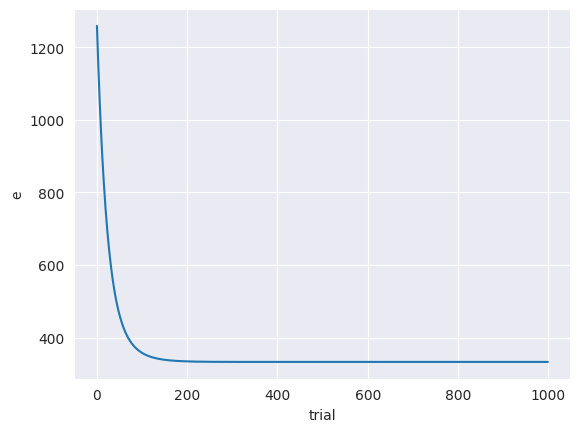

In [6]:
import seaborn as sns
import pandas as pd

df = pd.DataFrame(np.array(list(enumerate(errors))), columns=['trial', 'e'])
sns.lineplot(data=df, x="trial", y="e")

[1258.9618720021285,
 1220.9286910888986,
 1184.5222863003787,
 1149.6729286476398,
 1116.3116385976864,
 1084.376605875932,
 1053.8020665376305,
 1024.5295820205158,
 996.4996480164091,
 969.6641814110028,
 943.9699262699104,
 919.3633831071996,
 895.7997170032697,
 873.2335656651094,
 851.623247080882,
 830.9261456410313,
 811.1032491564848,
 792.1162113346115,
 773.9276759004347,
 756.5059415471835,
 739.8161761393435,
 723.8283351392469,
 708.5109441469773,
 693.8352322349838,
 679.7709360457612,
 666.2954378912327,
 653.3830635358712,
 641.0074505689788,
 629.1453248458427,
 617.7764777006546,
 606.8783869505945,
 596.4315149745581,
 586.4154062566284,
 576.8146223490048,
 567.606462667894,
 558.7757295723809,
 550.3068593084511,
 542.1848356469982,
 534.3947458428759,
 526.9210586954041,
 519.7515326605305,
 512.8711631063342,
 506.26827786905864,
 499.93074343265187,
 493.8496268508409,
 488.0110293460534,
 482.40472940186476,
 477.0215630686659,
 471.85215268096306,
 466.887123

In [9]:
np.array(list(enumerate(errors)))

array([[0.00000000e+00, 1.25896187e+03],
       [1.00000000e+00, 1.22092869e+03],
       [2.00000000e+00, 1.18452229e+03],
       ...,
       [9.97000000e+02, 3.32820820e+02],
       [9.98000000e+02, 3.32820837e+02],
       [9.99000000e+02, 3.32820492e+02]])

In [5]:
errors

[1608.5939116786963,
 315.7063009947255,
 315.7063009947255,
 315.7063009947255,
 315.7063009947255,
 315.7063009947255,
 315.7063009947255,
 315.7063009947255,
 315.7063009947255,
 315.7063009947255,
 315.7063009947255,
 315.7063009947255,
 315.7063009947255,
 315.7063009947255,
 315.7063009947255,
 315.7063009947255,
 315.7063009947255,
 315.7063009947255,
 315.7063009947255,
 315.7063009947255,
 315.7063009947255,
 315.7063009947255,
 315.7063009947255,
 315.7063009947255,
 315.7063009947255,
 315.7063009947255,
 315.7063009947255,
 315.7063009947255,
 315.7063009947255,
 315.7063009947255,
 315.7063009947255,
 315.7063009947255,
 315.7063009947255,
 315.7063009947255,
 315.7063009947255,
 315.7063009947255,
 315.7063009947255,
 315.7063009947255,
 315.7063009947255,
 315.7063009947255,
 315.7063009947255,
 315.7063009947255,
 315.7063009947255,
 315.7063009947255,
 315.7063009947255,
 315.7063009947255,
 315.7063009947255,
 315.7063009947255,
 315.7063009947255,
 315.7063009947255,